In [1]:
# Import libraries
import tarfile
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors

In [2]:
import os
train_images_path = "Task01_BrainTumour_2D/training_images"
train_labels_path = "Task01_BrainTumour_2D/training_labels"
train_images_files = [f for f in os.listdir(train_images_path) if os.path.isfile(os.path.join(train_images_path, f))]
train_labels_files = [f for f in os.listdir(train_labels_path) if os.path.isfile(os.path.join(train_labels_path, f))]

In [3]:
def normalise_intensity(image, thres_roi=1.0):
    """ Normalise the image intensity by the mean and standard deviation """
    # ROI defines the image foreground
    val_l = np.percentile(image, thres_roi)
    roi = (image >= val_l)
    mu, sigma = np.mean(image[roi]), np.std(image[roi])
    eps = 1e-6
    image2 = (image - mu) / (sigma + eps)
    return image2


class BrainImageSet(Dataset):
    """ Brain image set """
    def __init__(self, image_path, label_path='', deploy=False):
        self.image_path = image_path
        self.deploy = deploy
        self.images = []
        self.labels = []

        image_names = sorted(os.listdir(image_path))
        for image_name in image_names:
            # Read the image
            image = imageio.imread(os.path.join(image_path, image_name))
            self.images += [image]

            # Read the label map
            if not self.deploy:
                label_name = os.path.join(label_path, image_name)
                label = imageio.imread(label_name)
                self.labels += [label]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get an image and perform intensity normalisation
        # Dimension: XY
        image = normalise_intensity(self.images[idx])

        # Get its label map
        # Dimension: XY
        label = self.labels[idx]
        return image, label

    def get_random_batch(self, batch_size):
        # Get a batch of paired images and label maps
        # Dimension of images: NCXY
        # Dimension of labels: NXY
        images, labels = [], []

        randidx = [random.randint(0, len(self)-1) for i in range(batch_size)]
        for i in range(batch_size):
            tup = self[randidx[i]]
            images.append(tup[0])
            labels.append(tup[1])

        images, labels = np.array(images)[:, np.newaxis, :, :], np.array(labels)
        return images, labels

In [4]:
train_set = BrainImageSet('Task01_BrainTumour_2D/training_images', 'Task01_BrainTumour_2D/training_labels')
test_set = BrainImageSet('Task01_BrainTumour_2D/test_images', 'Task01_BrainTumour_2D/test_labels')

/var/folders/ly/x8psxl8d75q0jcffk6_fm8zm0000gn/T/ipykernel_11567/264090107.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(image_path, image_name))
/var/folders/ly/x8psxl8d75q0jcffk6_fm8zm0000gn/T/ipykernel_11567/264090107.py:29: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label = imageio.imread(label_name)


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, input_channel=1, num_classes=4):
        super(SimpleCNN, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(input_channel, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),  # Downsample

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),  # Downsample

        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2), # Upsample
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),  # Upsample
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, num_classes, kernel_size=1)  # Output layer
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {0}'.format(device))

# Build the model
num_class = 4

Device: cpu


In [7]:
# Train the model
num_iter = 2500
train_batch_size = 16
eval_batch_size = 16
model_dir = 'saved_models'

# Initialize the CNN model
cnn_model = SimpleCNN(input_channel=1, num_classes=num_class)
cnn_model = cnn_model.to(device)

# Optimizer for CNN
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss() 
# Training the CNN model
num_iter_cnn = 2500  # Adjust as needed
start_cnn = time.time()
for it in range(1, 1 + num_iter_cnn):
    cnn_model.train()

    # Get a batch of images and labels
    images, labels = train_set.get_random_batch(train_batch_size)
    images, labels = torch.from_numpy(images), torch.from_numpy(labels)
    images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)

    # Forward pass
    cnn_optimizer.zero_grad()
    outputs = cnn_model(images)
    
    # Reshape the outputs to match labels using interpolate (or other methods)
    outputs = F.interpolate(outputs, size=labels.shape[1:], mode='bilinear', align_corners=False) 
    # OR
    # outputs = F.interpolate(outputs, size=labels.shape[-2:], mode='bilinear', align_corners=False) 

    # Compute loss
    loss = criterion(outputs, labels) # Assuming criterion is CrossEntropyLoss
    # Backward pass and optimization
    loss.backward()
    cnn_optimizer.step()

    # Evaluate
    if it % 100 == 0:
        cnn_model.eval()
        with torch.no_grad():
            images, labels = test_set.get_random_batch(eval_batch_size)
            images, labels = torch.from_numpy(images), torch.from_numpy(labels)
            images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
            outputs = cnn_model(images)

            # Reshape the outputs to match labels during evaluation as well
            outputs = F.interpolate(outputs, size=labels.shape[1:], mode='bilinear', align_corners=False)
            # OR
            # outputs = F.interpolate(outputs, size=labels.shape[-2:], mode='bilinear', align_corners=False) 

            test_loss = criterion(outputs, labels)

            print(f"CNN Iter: {it}, Test Loss: {test_loss.item()}")

    # Save the model
    if it % 500 == 0:
        torch.save(cnn_model.state_dict(), os.path.join(model_dir, f'cnn_model_{it}.pt'))

print(f'CNN Training took {time.time() - start_cnn:.3f}s in total.')

CNN Iter: 100, Test Loss: 0.6175209283828735
CNN Iter: 200, Test Loss: 0.1314091682434082
CNN Iter: 300, Test Loss: 0.08944918215274811
CNN Iter: 400, Test Loss: 0.09714579582214355
CNN Iter: 500, Test Loss: 0.06866417825222015
CNN Iter: 600, Test Loss: 0.0632663145661354
CNN Iter: 700, Test Loss: 0.0502825528383255
CNN Iter: 800, Test Loss: 0.07901476323604584
CNN Iter: 900, Test Loss: 0.06320640444755554
CNN Iter: 1000, Test Loss: 0.03328785300254822
CNN Iter: 1100, Test Loss: 0.06370200961828232
CNN Iter: 1200, Test Loss: 0.06565152108669281
CNN Iter: 1300, Test Loss: 0.044977497309446335
CNN Iter: 1400, Test Loss: 0.05394718050956726
CNN Iter: 1500, Test Loss: 0.038240306079387665
CNN Iter: 1600, Test Loss: 0.02961687743663788
CNN Iter: 1700, Test Loss: 0.03980371356010437
CNN Iter: 1800, Test Loss: 0.04488397762179375
CNN Iter: 1900, Test Loss: 0.03428398445248604
CNN Iter: 2000, Test Loss: 0.045390475541353226
CNN Iter: 2100, Test Loss: 0.040081724524497986
CNN Iter: 2200, Test L

Accuracy: 0.9861


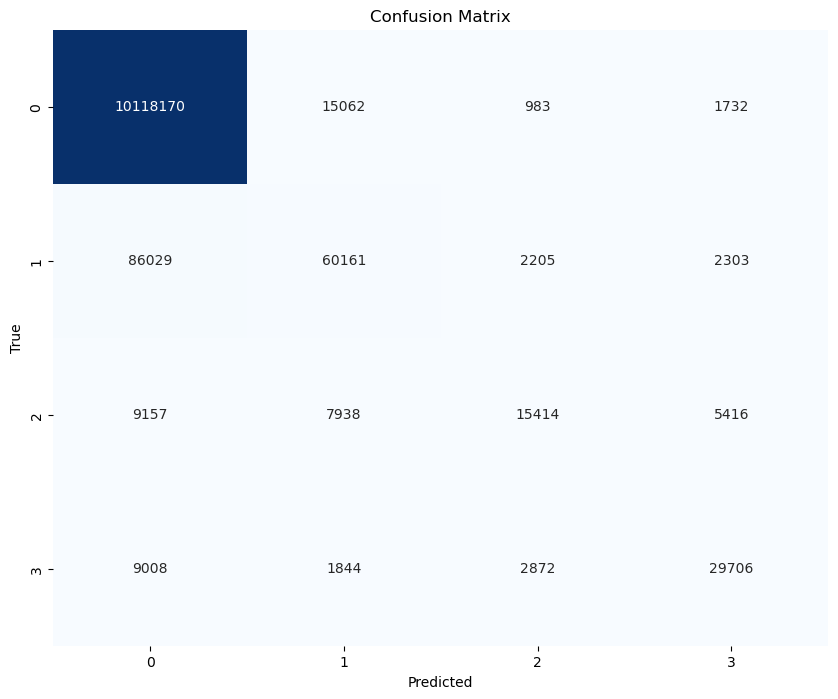

              precision    recall  f1-score   support

     Class 0       0.99      1.00      0.99  10135947
     Class 1       0.71      0.40      0.51    150698
     Class 2       0.72      0.41      0.52     37925
     Class 3       0.76      0.68      0.72     43430

    accuracy                           0.99  10368000
   macro avg       0.79      0.62      0.69  10368000
weighted avg       0.98      0.99      0.98  10368000



In [17]:
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, num_classes):
    # Flatten the arrays and convert to integers
    y_true = np.array(y_true).flatten().astype(int)  
    y_pred = np.array(y_pred).flatten().astype(int) 
    
    cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# After training loop
cnn_model.eval()
all_preds = []
all_labels = []

# Number of batches to evaluate
num_eval_batches = len(test_set) // eval_batch_size  # Calculate how many batches you can evaluate
num_classes = cnn_model(images).shape[1]
with torch.no_grad():
    for it in range(num_eval_batches):  # Loop over the number of batches
        images, labels = test_set.get_random_batch(eval_batch_size)
        images, labels = torch.from_numpy(images), torch.from_numpy(labels)
        images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
        
        outputs = cnn_model(images)
        
        # Reshape the outputs to match labels during evaluation
        outputs = F.interpolate(outputs, size=labels.shape[1:], mode='bilinear', align_corners=False)
        
        # Get predictions
        _, predicted = torch.max(outputs.data, 1)
        
        # Flatten the predictions and labels before extending the lists
        all_preds.extend(predicted.cpu().numpy().flatten())  
        all_labels.extend(labels.cpu().numpy().flatten()) 

# Calculate accuracy
accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f'Accuracy: {accuracy:.4f}')

# Plot confusion matrix
plot_confusion_matrix(all_labels, all_preds, num_classes)

# Generate classification report
report = classification_report(all_labels, all_preds, target_names=[f'Class {i}' for i in range(num_classes)])
print(report)

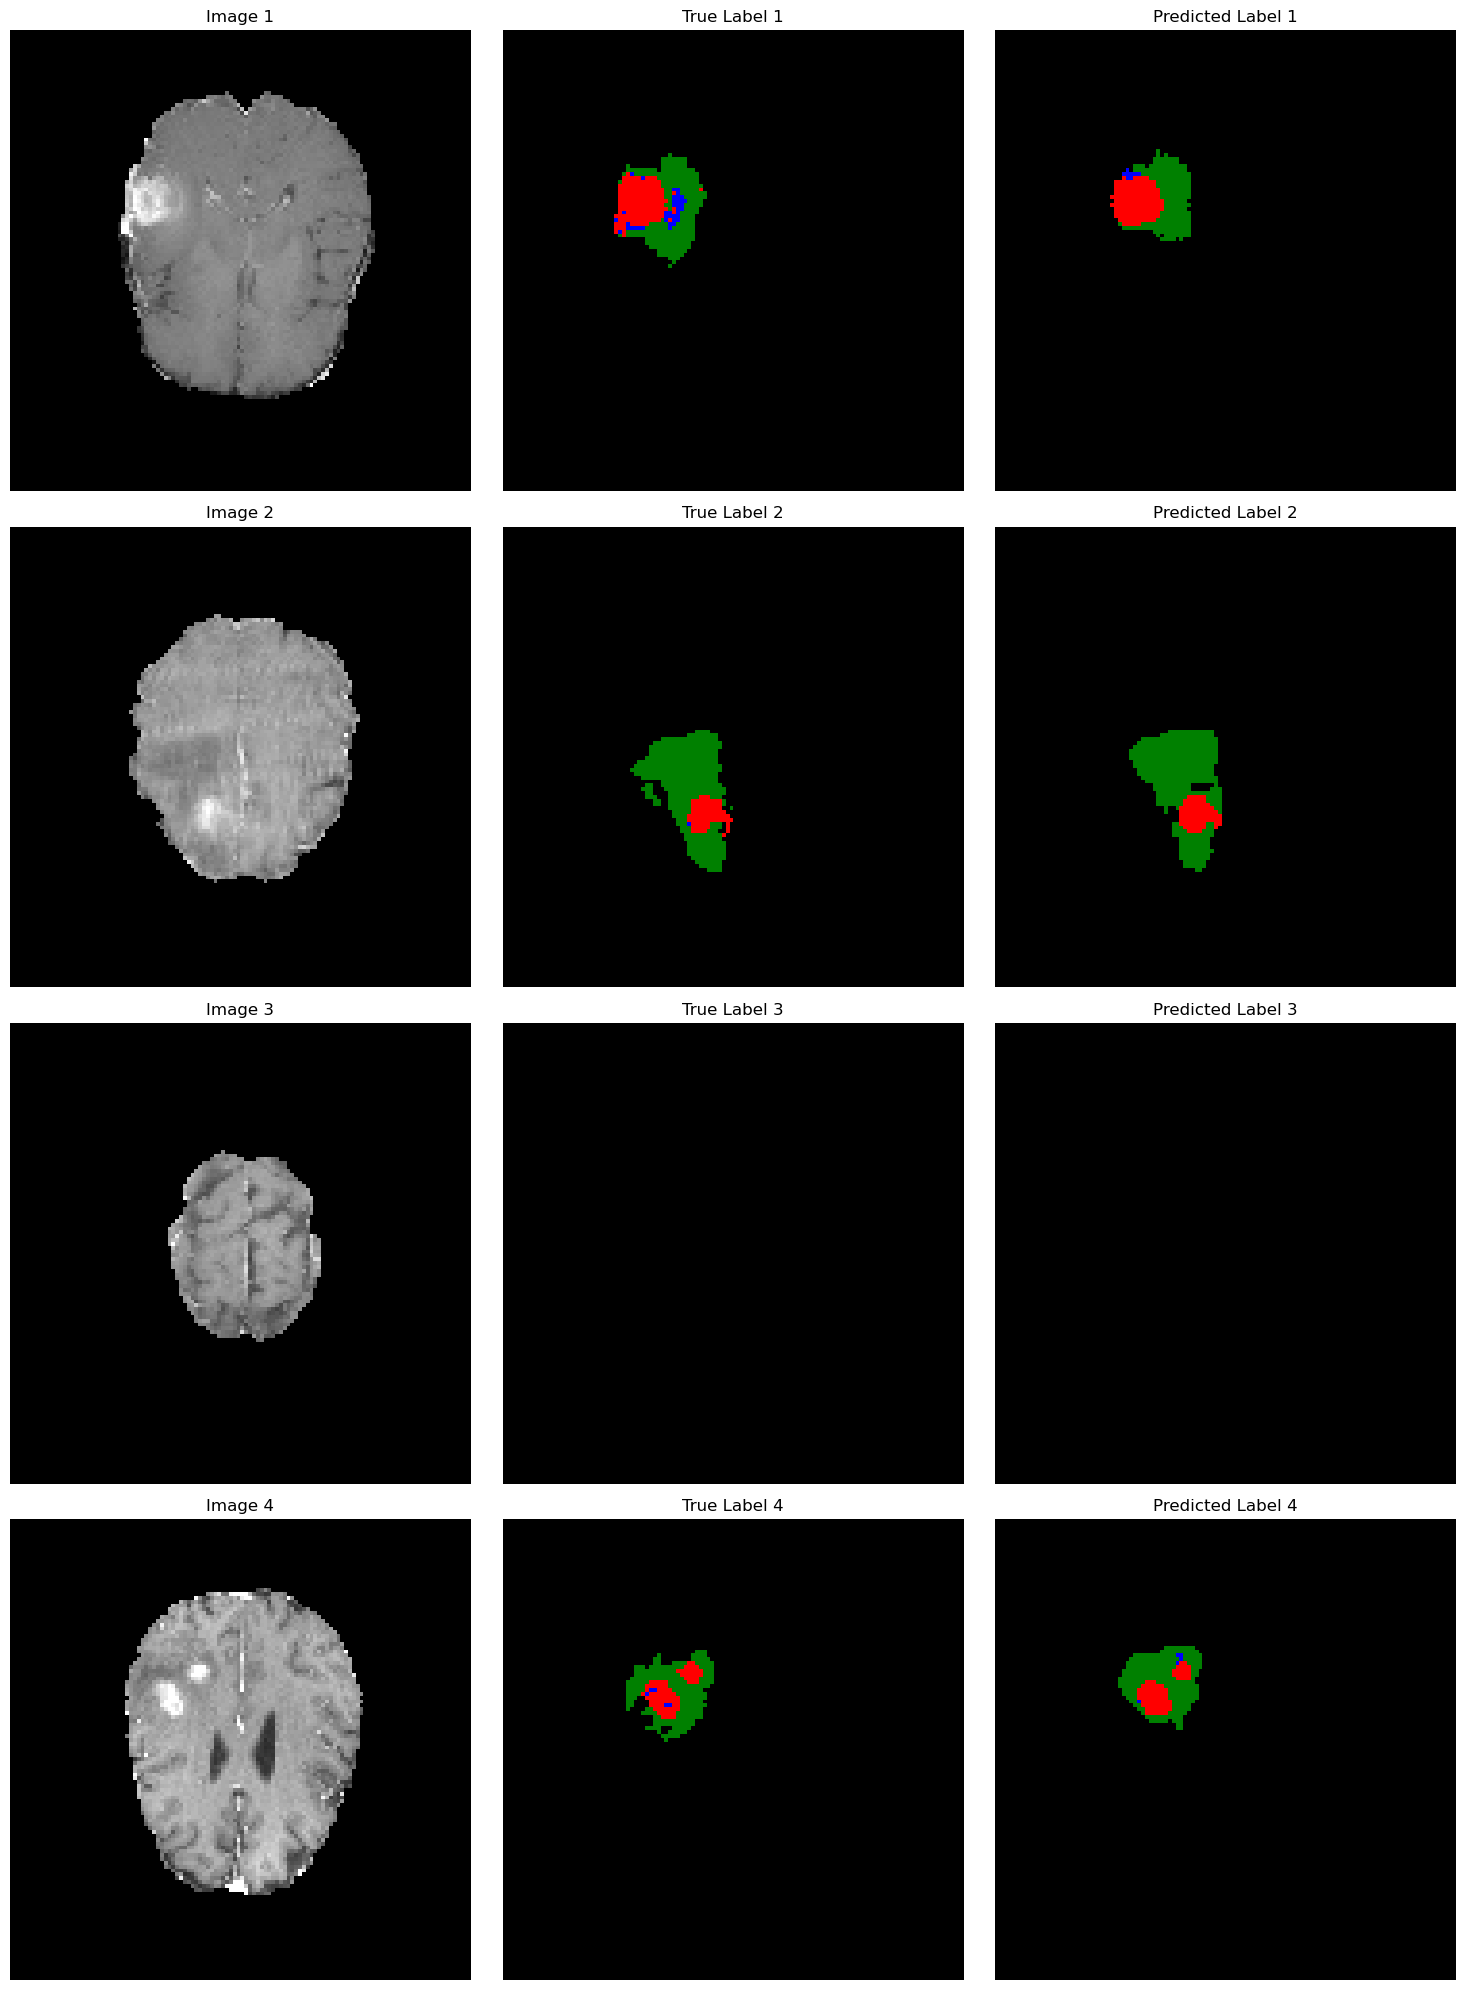

In [21]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors

def visualize_predictions(images, labels, model, device, n=4):
    """
    Visualize input images, ground truth labels, and predicted labels from CNN model.
    
    Args:
    images (Tensor): Batch of images.
    labels (Tensor): Ground truth labels.
    model (nn.Module): Trained CNN model.
    device (torch.device): Device (CPU/GPU) where the model is loaded.
    n (int): Number of examples to visualize.
    """
    # Move images and labels to the appropriate device
    images = images.to(device)
    labels = labels.to(device)

    # Set up colormap for visualization
    cmap_label = colors.ListedColormap(['black', 'green', 'blue', 'red'])

    # Prediction from the model
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        outputs = model(images)  # Forward pass
        _, preds = torch.max(outputs, 1)  # Get the predicted class labels

    # Set up the figure for visualization
    fig = plt.figure(figsize=(15, 20))
    rows, columns = 4, 3  # Number of rows and columns for the subplot grid

    for i in range(min(n, len(images))):  # Display n examples (or fewer if dataset is smaller)
        image = images[i].cpu().numpy().transpose(1, 2, 0)  # Convert to H x W x C (for visualization)
        label = labels[i].cpu().numpy()
        pred = preds[i].cpu().numpy()

        # Image
        fig.add_subplot(rows, columns, 3*(i+1) - 2)
        plt.imshow(image, cmap='gray')
        plt.title(f"Image {i + 1}")
        plt.axis('off')

        # Ground Truth
        fig.add_subplot(rows, columns, 3*(i+1) - 1)
        plt.imshow(label, cmap=cmap_label)
        plt.title(f"True Label {i + 1}")
        plt.axis('off')

        # Predicted Output
        fig.add_subplot(rows, columns, 3*(i+1))
        plt.imshow(pred, cmap=cmap_label)
        plt.title(f"Predicted Label {i + 1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Assuming 'test_set' is your test dataset and 'cnn_model' is the CNN model you trained
images, labels = test_set.get_random_batch(len(test_set))
images_t, labels_t = torch.from_numpy(images), torch.from_numpy(labels)
images_t, labels_t = images_t.to(device, dtype=torch.float32), labels_t.to(device, dtype=torch.long)

# Call the function to visualize predictions
visualize_predictions(images_t, labels_t, cnn_model, device, n=4)
